In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
import math
import torch_geometric
import pandas as pd
import geopandas as gpd
import momepy
import networkx as nx

from utils.load_geodata import load_gdf, load_graph, process_graph
from utils.constants import project_root, dataset_root
from utils.constants import rank_fields, log_fields, ignore_fields, all_feature_fields, feats, included_places

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
!nvidia-smi

/vol/bitbucket/wwc4618/venv/lib/python3.8/site-packages/geopandas/_compat.py:111: UserWarning: The Shapely GEOS version (3.9.1-CAPI-1.14.2) is incompatible with the GEOS version PyGEOS was compiled with (3.10.1-CAPI-1.16.0). Conversions between both will be slow.
  warnings.warn(


Mon Apr 18 16:33:56 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 510.47.03    Driver Version: 510.47.03    CUDA Version: 11.6     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  Off  | 00000000:21:00.0 Off |                  N/A |
| 25%   39C    P8     1W / 250W |   2523MiB / 11264MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Dataset Construction

In [2]:
# training_places = ['Coventry'] # for testing
training_places = ['Leeds', 'Cambridge', 'Coventry', 'Bristol', 'Leicester', 'Glasgow']
# training_places = [full_dataset_label]
test_places = ['Leeds', 'Manchester', 'Sheffield', 'Liverpool', 'Edinburgh', 'Wales']
true_inductive = ['nashville indiana', 'belfast', 'manhattan', 'singapore', 'tokyo']


# Projection
from pyproj import CRS, Transformer
crs_proj = CRS.from_epsg(27700)
crs_4326 = CRS("WGS84")
transformer = Transformer.from_crs(crs_4326, crs_proj)

def proj_and_reorder_bounds(bbox):
  S, W, N, E = bbox
  [S, N], [W, E] = transformer.transform([S, N], [W, E])
  return (S, W, N, E)


In [4]:
from shapely.geometry import LineString

# Data processing parameters
radii = { # metres
    '2km': 2000,
    '10km': 10000,
    '100km': 100000
}
radius = '2km' # for larger radii either turn off boundary masking or widen bbox
modifier = 'rank'
geoms = 2
classes = 0

def add_boundary_mask(gdf, place, rad, verbose=False):
    """Add flag column to indicate geometries within 'rad' of the bounding box
       No masking if loading full dataset"""
    if place == full_dataset_label:
        s = True
        masked_count = 0
    else:
        if place in bboxes:
            # Use defined boundaries
            S, W, N, E = proj_and_reorder_bounds(bboxes[place])
        else:
            # Use total bounds (For osmnx-loaded graphs)
            W, S, E, N = gdf.geometry.total_bounds
        boundary_line = LineString([(S, W), (N, W), (N, E), (S, E), (S, W)])
        boundary = boundary_line.buffer(radii[rad])
        s = gdf.geometry.disjoint(boundary)
        masked_count = gdf.size - s.sum()
    if verbose:
        print(f'Masking {masked_count} out of {gdf.size} geometries within boundary buffer')
    gdf['boundary_mask'] = s


# Construct SSx Graph dataset

In [2]:
import os
import os.path as osp
from itertools import chain
from virtual_node import VirtualNode
from torch_geometric.utils.convert import from_networkx
from torch_geometric.transforms import OneHotDegree, NormalizeFeatures
from torch_geometric.data import Batch, InMemoryDataset, download_url, extract_zip

# For one hot encoding of node degrees
max_deg = 16

def process_graph(g, feature_fields=[]):
    node_fields = set(chain.from_iterable(d.keys() for *_, d in g.nodes(data=True)))
    to_delete_fields = [field for field in node_fields if field not in feature_fields]
    for _, d in g.nodes(data=True):
        # remove non float-attributes
        for attr in to_delete_fields:
            del d[attr]
    return g

def print_graph_properties(g):
    # Gather some statistics about the graph.
    print(f'Number of nodes: {g.num_nodes}')
    print(f'Number of edges: {g.num_edges}')
    print(f'Average node degree: {g.num_edges / g.num_nodes:.2f}')
    print(f'Number of training nodes: {g.train_mask.sum()}')
    print(f'Training node label rate: {int(g.train_mask.sum()) / g.num_nodes:.2f}')
    print(f'Has isolated nodes: {g.has_isolated_nodes()}')
    print(f'Has self-loops: {g.has_self_loops()}')
    print(f'Is undirected: {g.is_undirected()}')

def load_graphs(df, la_col_name, virtual_node=False,
                feature_fields=[], target_attrs=[]):
    print('Test')
    data_list = []
    la_names = df[la_col_name].unique()
    for place in included_places:
        if place in la_names:
            g = load_graph(place, feature_fields, verbose=True)
            
            # Normalize node features
            g = NormalizeFeatures()(g)
            
            # Add virtual node
            if virtual_node:
                g = VirtualNode()(g)
            
            # One hot encode degree if no node features
            if g.num_node_features == 0:
                g = OneHotDegree(max_deg)(g)
            
            # Get row corresponding to place
            row = df.query(f'`{la_col_name}` == "{place}"')

            # Obtain target attribute(s)
            ys = []
            for target in target_attrs:
                ys.append(row.iloc[0][target])
            
            # Set graph target attribute
            g.y = torch.tensor([ys])
            data_list.append(g)
    return data_list


In [ ]:
def construct_ssx_dataset():
    dataset = [ load_graph(place, all_feature_fields, verbose=True) \
                for place in included_places ]
    torch.save(dataset, f'{dataset_root}/ssx_dataset_connected.pt')
    return dataset
dataset = construct_ssx_dataset()

In [2]:
def split_row(row):
    code1, code2 = row.iloc[0]['Code'].split('/')
    name1, name2 = row.iloc[0]['Name'].split('/')
    row1 = row.copy()
    row1['Code'] = code1
    row1['Name'] = name1
    row2 = row.copy()
    row2['Code'] = code2
    row2['Name'] = name2
    return pd.concat([row1, row2])
    
def load_city_cluster_df(numeric=True):
    df = pd.read_excel(f'{dataset_root}/clustermembershipv2.xls', sheet_name='Clusters by Local Authority', header=9)
    df = df[['Code', 'Name', 'Supergroup Name', 'Group Name', 'Subgroup Name']]
    
    # Remove last two lines (empty rows)
    df = df[:-2]
    
    # Unmerge London/Westminster and Cornwall/Isles of Scilly
    lon_wes_row = df.query('Name == "City of London/Westminster"')
    corn_isles_row = df.query('Name == "Cornwall/Isles of Scilly"')
    df = pd.concat([df, split_row(lon_wes_row), split_row(corn_isles_row)])
    
    df['Supergroup Name'] = df['Supergroup Name'].astype('category')
    df['Group Name'] = df['Group Name'].astype('category')
    df['Subgroup Name'] = df['Subgroup Name'].astype('category')
    
    if numeric:
        # Turn categorical data into numeric
        cat_columns = df.select_dtypes(['category']).columns
        df[cat_columns] = df[cat_columns].apply(lambda x: x.cat.codes)
    # subtract one to make it 0 indexed
    
    return df

def load_gva_df(): 
    gva_df = pd.read_excel(f'{dataset_root}/regionalgvaibylainuk.xls', sheet_name='Total GVA', header=2)
    return gva_df

def load_deprivation_df():
    sheets_and_cols = {
        'IMD': 'IMD',
        'Income': 'Income',
        'Employment': 'Employment',
        'Education': 'Education, Skills and Training',
        'Health': 'Health Deprivation and Disability',
        'Crime': 'Crime',
        'Barriers': 'Barriers to Housing and Services',
        'Living': 'Living Environment',
        'IDACI': 'Income Deprivation Affecting Children Index (IDACI)',
        'IDAOPI': 'Income Deprivation Affecting Older People (IDAOPI)',
    }
    id_cols = ['Local Authority District code (2013)', 'Local Authority District name (2013)']
    dep_metrics = ['Average rank', 'Average score']
    
    out_df = None
    for sheet in sheets_and_cols:
        dep_df = pd.read_excel(f'{dataset_root}/File_10_ID2015_Local_Authority_District_Summaries.xlsx',
                               sheet_name=sheet, header=0)
        cols_to_read = id_cols + [f'{sheets_and_cols[sheet]} - {metric}' for metric in dep_metrics]  
        dep_df = dep_df[cols_to_read]
        if out_df is not None:
            out_df = out_df.merge(dep_df, on=id_cols)
        else:
            out_df = dep_df
    return out_df
    


# gva_data_list = load_graphs(load_gva_df(), 'LA_name', target_attrs=[2015])
# torch.save(gva_data_list, 'datasets/ssx_gva_dataset.pt')

# city_cluster_data_list = load_graphs(load_city_cluster_df(), 'Name', feature_fields=all_feature_fields,
#                             target_attrs=['Supergroup Code', 'Group Code', 'Subgroup Code'])

# torch.save(city_cluster_data_list, 'datasets/ssx_cities_dataset_norm.pt')

df = load_deprivation_df()
df

,Local Authority District code (2013),Local Authority District name (2013),IMD - Average rank,IMD - Average score,Income - Average rank,Income - Average score,Employment - Average rank,Employment - Average score,"Education, Skills and Training - Average rank","Education, Skills and Training - Average score",...,Crime - Average rank,Crime - Average score,Barriers to Housing and Services - Average rank,Barriers to Housing and Services - Average score,Living Environment - Average rank,Living Environment - Average score,Income Deprivation Affecting Children Index (IDACI) - Average rank,Income Deprivation Affecting Children Index (IDACI) - Average score,Income Deprivation Affecting Older People (IDAOPI) - Average rank,Income Deprivation Affecting Older People (IDAOPI) - Average score
0,E06000001,Hartlepool,21886.60,33.178,22711.37,0.239,24876.54,0.211,20101.48,30.510,...,17360.29,0.078,8132.08,13.128,6723.11,8.260,22579.19,0.307,20692.34,0.244
1,E06000002,Middlesbrough,23562.71,40.216,23472.98,0.268,24731.49,0.216,22728.01,40.640,...,23468.17,0.633,13789.08,18.316,10521.28,12.907,24366.41,0.357,19587.43,0.253
2,E06000003,Redcar and Cleveland,19716.01,28.567,20485.88,0.204,23187.19,0.186,19185.28,27.875,...,16326.90,-0.013,8251.14,12.863,6150.27,7.923,21220.74,0.273,16755.19,0.189
3,E06000004,Stockton-on-Tees,17046.82,24.625,17740.60,0.177,19639.45,0.156,16660.09,24.637,...,13642.44,-0.263,12889.76,17.844,5674.10,7.068,18134.25,0.226,15487.05,0.179
4,E06000005,Darlington,17423.32,23.639,18141.06,0.168,20106.98,0.150,16385.06,22.569,...,19412.70,0.224,7457.80,12.346,9002.91,10.710,18234.49,0.215,15816.84,0.176
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
321,E09000029,Sutton,12063.57,14.579,13697.34,0.111,12238.97,0.086,11629.13,12.576,...,18649.65,0.163,15338.03,19.784,16296.96,19.062,15248.39,0.159,12180.12,0.129
322,E09000030,Tower Hamlets,25486.40,35.657,25624.12,0.253,19994.04,0.138,16654.45,18.831,...,25365.55,0.762,29089.59,37.748,27007.76,39.823,28983.38,0.393,30626.21,0.497
323,E09000031,Waltham Forest,23744.54,30.190,22759.13,0.193,19861.43,0.128,17236.42,18.693,...,27260.33,0.860,29428.98,38.435,25539.47,35.439,23811.53,0.270,22673.23,0.251
324,E09000032,Wandsworth,15774.73,18.295,15537.30,0.127,11170.92,0.079,7358.71,7.250,...,22396.34,0.439,19644.23,24.595,26639.14,38.202,17873.64,0.207,21646.04,0.234


## Load saved dataset and process into dataloader

In [19]:
from torch_geometric.loader import DataLoader
torch.manual_seed(12345)

def print_dataset_stats(dataset):
    print(f'Number of graphs: {len(dataset)}')
    data = dataset[0]  # Get the first graph object.
    print()
    print(data)
    print('=============================================================')

    # Gather some statistics about the first graph.
    print(f'Number of nodes: {data.num_nodes}')
    print(f'Number of node features: {data.num_node_features}')
    print(f'Number of edges: {data.num_edges}')
    print(f'Number of edge features: {data.num_edge_features}')
    print(f'Average node degree: {data.num_edges / data.num_nodes:.2f}')
    print(f'Has isolated nodes: {data.has_isolated_nodes()}')
    print(f'Has self-loops: {data.has_self_loops()}')
    print(f'Is undirected: {data.is_undirected()}')

def process_dataset(dataset, split=0.8, batch_size=64, verbose=False):
    # Train-test split
    idx = torch.randperm(len(dataset))
    split_idx = math.floor(split * len(dataset))
    train_idx = idx[:split_idx]
    test_idx = idx[split_idx:]
    train_dataset = [dataset[i] for i in train_idx]
    test_dataset = [dataset[i] for i in test_idx]
    if verbose:
        print(f'Number of training graphs: {len(train_dataset)}')
        print(f'Number of test graphs: {len(test_dataset)}')
    
    # Load graphs into dataloader
    train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)
    if verbose:
        for step, data in enumerate(train_loader):
            print(f'Step {step + 1}:')
            print('=======')
            print(f'Number of graphs in the current batch: {data.num_graphs}')
            print(data)
            print()

    return dataset, train_loader, test_loader

def get_data_stats(dataset, target_index):
    num_node_features = dataset[0].num_node_features
    try:
        targets = [data.y[0][target_index].item() for data in dataset]
    except IndexError:
        return num_node_features, 1
    return num_node_features, max(targets) + 1 # 0-indexed


dataset = torch.load('datasets/ssx_cities_dataset_normalized.pt')
dataset, train_loader, test_loader = process_dataset(dataset, verbose=True)

Number of training graphs: 277
Number of test graphs: 70
Step 1:
Number of graphs in the current batch: 64
DataBatch(edge_index=[2, 1852666], x=[320225, 17], edge_attr=[1852666, 1], edge_type=[1852666], y=[64, 3], batch=[320225], ptr=[65])

Step 2:
Number of graphs in the current batch: 64
DataBatch(edge_index=[2, 1997694], x=[344754, 17], edge_attr=[1997694, 1], edge_type=[1997694], y=[64, 3], batch=[344754], ptr=[65])

Step 3:
Number of graphs in the current batch: 64
DataBatch(edge_index=[2, 2076266], x=[345558, 17], edge_attr=[2076266, 1], edge_type=[2076266], y=[64, 3], batch=[345558], ptr=[65])

Step 4:
Number of graphs in the current batch: 64
DataBatch(edge_index=[2, 1849294], x=[316517, 17], edge_attr=[1849294, 1], edge_type=[1849294], y=[64, 3], batch=[316517], ptr=[65])

Step 5:
Number of graphs in the current batch: 21
DataBatch(edge_index=[2, 443314], x=[77694, 17], edge_attr=[443314, 1], edge_type=[443314], y=[21, 3], batch=[77694], ptr=[22])



## OLS with Mean SSx Metrics

In [15]:
from sklearn.linear_model import LinearRegression

num_node_features = dataset[0].num_node_features
X = np.zeros((len(dataset), num_node_features))
y = np.zeros(len(dataset))

# Get mean vectors for each graph
for i, graph in enumerate(dataset):
    X[i] = graph.x.mean(dim=0) # shape [17]
    y[i] = graph.y[0]

reg = LinearRegression().fit(X, y)
print(reg.score(X, y)) # transductive
pd.DataFrame({ 'features': feature_fields, 'coefficients': reg.coef_ })

NameError: name 'dataset' is not defined

In [2]:
# link_pred_dataset1 = torch.load(f'{dataset_root}/link_pred_metrics_1_iter1.pt')

# link_pred_dataset2 = torch.load(f'{dataset_root}/link_pred_metrics_1_iter2.pt')

link_pred_dataset3 = torch.load(f'{dataset_root}/link_pred_metrics_1_iter3.pt')
link_pred_dataset1.keys(), link_pred_dataset2.keys(), link_pred_dataset3.keys()

NameError: name 'link_pred_dataset1' is not defined

In [7]:
import copy
metrics = ['auc', 'ap', 'precision', 'recall', 'f1']
def transform_dataset(link_pred_dataset):
    new_dataset = {}
    for key in link_pred_dataset:
        new_dataset[key] = copy.deepcopy(link_pred_dataset[key])
        avg_dict = { metric: 0 for metric in metrics }
        self_dict = new_dataset[key]['tests'][key]
        for place2 in new_dataset[key]['tests']:
            for metric in metrics:
                avg_dict[metric] += new_dataset[key]['tests'][place2][metric]
        for metric in metrics:
            avg_dict[metric] /= len(new_dataset[key]['tests'])
        new_dataset[key]['transductive'] = self_dict
        new_dataset[key]['inductive-avg'] = avg_dict
        del new_dataset[key]['tests']
    return new_dataset

# link_pred1 = transform_dataset(link_pred_dataset1)
# link_pred2 = transform_dataset(link_pred_dataset2)
link_pred['Southwark']

{'total_loss': [1.0783421993255615],
 'recon_loss': [1.0783421993255615],
 'kl_loss': [0.0],
 'train_auc': [0.773520039092519],
 'train_ap': [0.39502647439489635],
 'test_auc': [0.7118659379084014],
 'test_ap': [0.3069965326448055],
 'transductive': {'z': [tensor([[ 0.0346,  0.1279,  0.6907,  ...,  0.6256, -0.0979,  0.2236],
           [ 0.2389,  0.3416,  0.9530,  ...,  0.8733, -0.3116,  0.1675],
           [ 0.3257,  0.3255,  0.7886,  ...,  0.7748, -0.3417,  0.0769],
           ...,
           [ 0.4678,  0.8063, -0.7783,  ..., -0.8199, -0.2907, -0.5933],
           [ 0.3466,  0.7134, -0.7816,  ..., -0.8577, -0.2493, -0.6122],
           [ 0.2637,  0.6214, -0.7959,  ..., -0.8275, -0.2254, -0.6304]],
          device='cuda:0', requires_grad=True)],
  'auc': 0.8477167630057804,
  'ap': 0.8893990221597325,
  'precision': 0.8215215061992959,
  'recall': 0.8614767255216693,
  'f1': 0.8410248374206691},
 'inductive-avg': {'auc': 0.7739426236111394,
  'ap': 0.8327926211512312,
  'precision': 

# OLS with Link Pred Metrics

In [54]:
from sklearn.linear_model import LinearRegression

def link_pred_regression(link_pred_dataset, link_pred_metrics):
    dep_df = load_deprivation_df()
    
    id_cols = ['Local Authority District name (2013)', 'Local Authority District code (2013)']
    scores = {}
    valid_places = [place for place in dep_df[id_cols[0]] \
                    if place in link_pred_dataset]
    print(f'Regressing with {len(valid_places)} local authorities')
    
    # Obtain deprivation statistics corresponding to retrieved metrics
    dep_df = dep_df.query(f'`{id_cols[0]}` == @valid_places')
    city_stats = [col for col in dep_df.columns if col not in id_cols]
    Ys = [dep_df[stat].values for stat in city_stats]

    for link_pred_metric in link_pred_metrics:
        if link_pred_metric in list(link_pred_dataset.values())[0]:
            # Retrieve the run-level results
            X = [link_pred_dataset[place][link_pred_metric] for place in valid_places]
            # Regress each city statistic against each run metric
            for stat_idx, city_stat in enumerate(city_stats):
                Y = Ys[stat_idx]
                reg = LinearRegression().fit(X, Y)
                score = reg.score(X, Y)
                scores[link_pred_metric, city_stat] = score
                print(f'R score for {link_pred_metric} against {city_stat}: {score}')
        else:
            # Retrieve both the transductive and inductive result
            X_trans = [[link_pred_dataset[place]['transductive'][link_pred_metric]] for place in valid_places]
            X_ind = [[link_pred_dataset[place]['inductive-avg'][link_pred_metric]] for place in valid_places]
            
            for stat_idx, city_stat in enumerate(city_stats):
                Y = Ys[stat_idx]
                reg = LinearRegression().fit(X_trans, Y)
                score = reg.score(X_trans, Y)
                scores[f'{link_pred_metric}_transductive', city_stat] = score
                print(f'Transductive {link_pred_metric} against {city_stat}: {score}')
                
                reg = LinearRegression().fit(X_ind, Y)
                score = reg.score(X_ind, Y)
                scores[f'{link_pred_metric}_inductive', city_stat] = score
                print(f'Inductive {link_pred_metric} against {city_stat}: {score}')
        
        
    return scores

metrics = ['train_auc', 'test_auc', 'train_ap', 'test_ap', 'f1', 'precision', 'recall', 'auc', 'ap']
link_pred_dataset = torch.load(f'{dataset_root}/link_pred_dataset_transformed.pt')
scores1 = link_pred_regression(link_pred_dataset, metrics)
print(scores1)

# link_pred_dataset2a = torch.load(f'{dataset_root}/link_pred_metrics_2_iter1.pt')
# link_pred_dataset2b = torch.load(f'{dataset_root}/link_pred_metrics_2_iter2.pt')
link_pred_dataset2 = {**link_pred_dataset2a, **link_pred_dataset2b}
scores2 = link_pred_regression(link_pred_dataset2, metrics)
print(scores2)

# df = pd.Series(scores).unstack()
# df.to_excel("output.xlsx")  

Regressing with 297 local authorities
R score for train_auc against IMD - Average rank: 0.1380854812888742
R score for train_auc against IMD - Average score: 0.13833015801478332
R score for train_auc against Income - Average rank: 0.1398825774436011
R score for train_auc against Income - Average score: 0.14861340060480488
R score for train_auc against Employment - Average rank: 0.03913229573303978
R score for train_auc against Employment - Average score: 0.036519501597339854
R score for train_auc against Education, Skills and Training - Average rank: 0.0015889052156796701
R score for train_auc against Education, Skills and Training - Average score: 0.003393139052418781
R score for train_auc against Health Deprivation and Disability - Average rank: 0.06300544596280555
R score for train_auc against Health Deprivation and Disability - Average score: 0.05033174344652347
R score for train_auc against Crime - Average rank: 0.3378635740443181
R score for train_auc against Crime - Average scor

# Node-level K-means Clustering

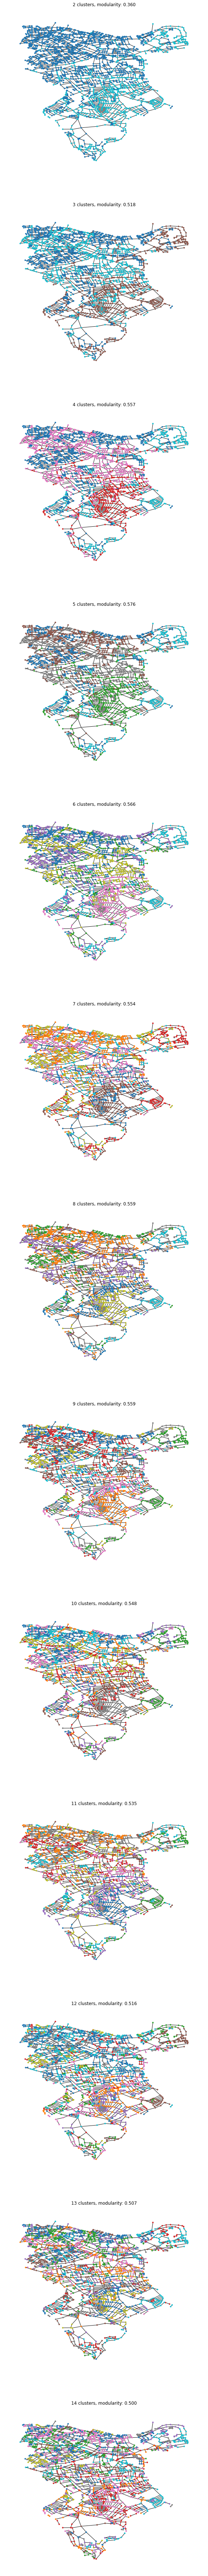

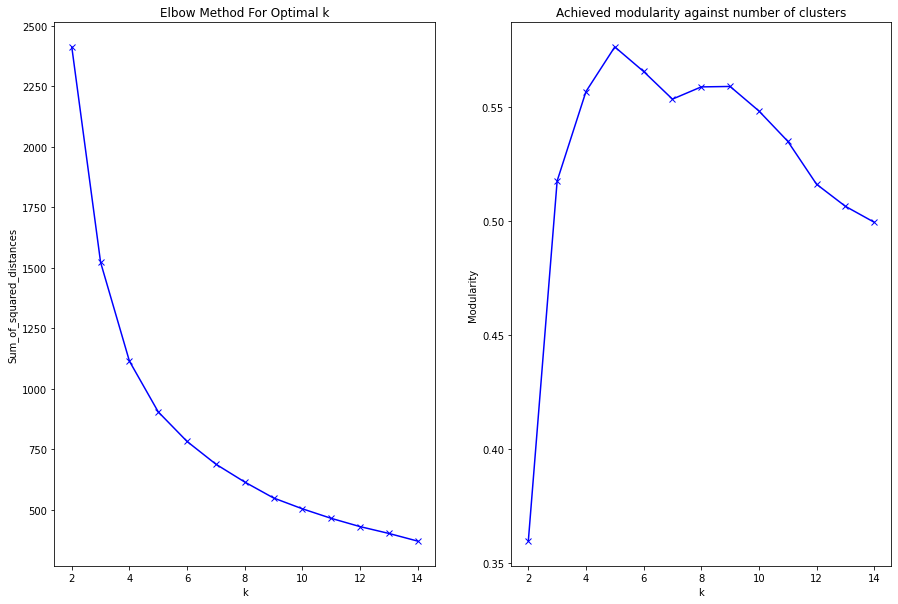

In [51]:
from sklearn.cluster import KMeans
import networkx.algorithms.community as nx_comm

def cluster(ssx_dataset, place, data_to_cluster=None, Ks=range(2,10), include_feats=rank_fields):
    X = [data.x for data in ssx_dataset if data.place == place][0]
    
    if data_to_cluster is None:
        # Get cluster data from ssx dataset
        feat_idx = torch.tensor([feats.index(feat) for feat in include_feats])
        data_to_cluster = torch.index_select(X, 1, feat_idx) if len(feat_idx) > 0 else None
    else:
        # Cluster data should have same length as ssx data (same number of nodes
        assert len(data_to_cluster) == len(X)
    
    gdf = load_gdf(place)
    streets = momepy.gdf_to_nx(gdf, approach='primal', multigraph=False)
    float32_node_dict = {(torch.tensor(c[0], dtype=torch.float32).item(),
                          torch.tensor(c[1], dtype=torch.float32).item()): c for c in streets}
    
    errors = []
    modularities = []
    f, ax = plt.subplots(len(Ks), 1, figsize=(10, len(Ks) * 10), sharex=True, sharey=True)
    for idx, k in enumerate(Ks):
        km = KMeans(n_clusters=k, random_state=0)
        km = km.fit(data_to_cluster)
        errors.append(km.inertia_)
        
        label_dict = {} # For assigning attributes
        label_to_nodes_dict = {k: [] for k in range(k)} # To compute modularity
        # Iterate over each node and add its designated label to the nx graph
        for i, label in enumerate(km.labels_):
            # Get node coordinates (the last two node attributes in pretransformed data)
            coords = X[i, -2].item(), X[i, -1].item()
            # Convert them into their full precision node coordinates
            coords = float32_node_dict[coords]
            label_dict[coords] = label
            label_to_nodes_dict[label].append(coords)
        # Compute modularity
        mod = nx_comm.modularity(streets, list(label_to_nodes_dict.values()))
        modularities.append(mod)
        
        # Set attributes on the original graph
        nx.set_node_attributes(streets, label_dict, 'label')

        # Plot original graph, coloring nodes as per their assigned label
        colors = [node[1]['label'] for node in streets.nodes(data=True)]
        axis = ax[idx] if len(Ks) > 1 else ax
        axis.set_title(f'{k} clusters, modularity: {mod:.3f}')
        nx.draw(streets, {n:[n[0], n[1]] for n in list(streets.nodes)}, node_size=10, node_color=colors, cmap='tab10', ax=axis)
    
    plt.show()
    f, ax = plt.subplots(1, 2, figsize=(15, 10))
    ax[0].plot(Ks, errors, 'bx-')
    ax[0].set_xlabel('k')
    ax[0].set_ylabel('Sum_of_squared_distances')
    ax[0].set_title('Elbow Method For Optimal k')
    ax[1].plot(Ks, modularities, 'bx-')
    ax[1].set_xlabel('k')
    ax[1].set_ylabel('Modularity')
    ax[1].set_title('Achieved modularity against number of clusters')
    plt.show()

def plot_latent_clusters(place, Ks=None):
    ssx_dataset = torch.load(f'{dataset_root}/ssx_dataset.pt')
    link_pred_dataset = torch.load(f'{dataset_root}/link_pred_dataset_transformed.pt')
    link_pred_data = link_pred_dataset[place]['transductive']['z'][0]
    cluster(ssx_dataset, place, data_to_cluster=link_pred_data.detach().cpu(), Ks=Ks)

plot_latent_clusters('Southwark', Ks=range(2,15))

# Network-level TSNE visualizations

In [77]:
cluster_df = load_city_cluster_df(numeric=False)
q = cluster_df.query(f'Name == "The Vale of Glamorgan"')
print(q.empty)

True


torch.Size([347, 19])
[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 347 samples in 0.000s...
[t-SNE] Computed neighbors for 347 samples in 0.021s...
[t-SNE] Computed conditional probabilities for sample 347 / 347
[t-SNE] Mean sigma: 2416812.531442


/vol/bitbucket/wwc4618/venv/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(


[t-SNE] KL divergence after 250 iterations with early exaggeration: 43.818298
[t-SNE] KL divergence after 1000 iterations: 0.131809


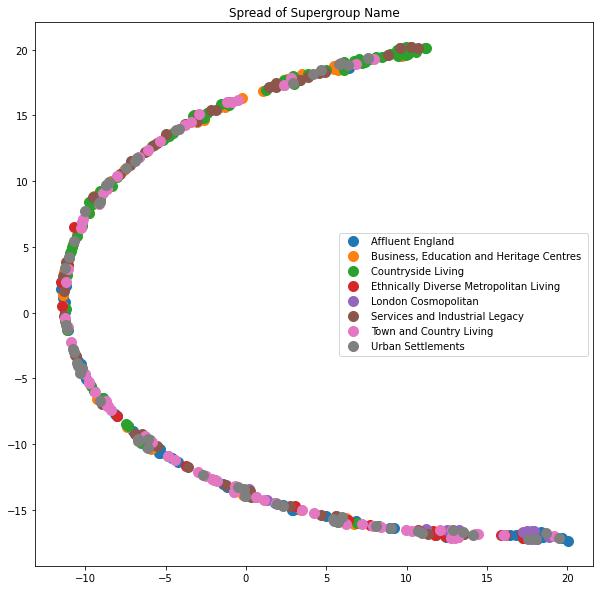

torch.Size([347, 4])
[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 347 samples in 0.000s...
[t-SNE] Computed neighbors for 347 samples in 0.004s...
[t-SNE] Computed conditional probabilities for sample 347 / 347
[t-SNE] Mean sigma: 0.017340
[t-SNE] KL divergence after 250 iterations with early exaggeration: 48.698982


/vol/bitbucket/wwc4618/venv/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(


[t-SNE] KL divergence after 1000 iterations: 0.314228


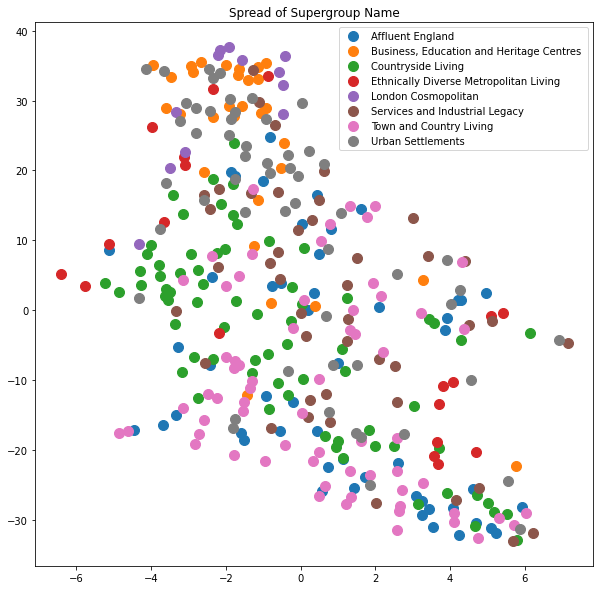

torch.Size([318, 10])
[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 318 samples in 0.000s...
[t-SNE] Computed neighbors for 318 samples in 0.006s...
[t-SNE] Computed conditional probabilities for sample 318 / 318
[t-SNE] Mean sigma: 0.040887


/vol/bitbucket/wwc4618/venv/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(


[t-SNE] KL divergence after 250 iterations with early exaggeration: 56.945492
[t-SNE] KL divergence after 1000 iterations: 1.154983


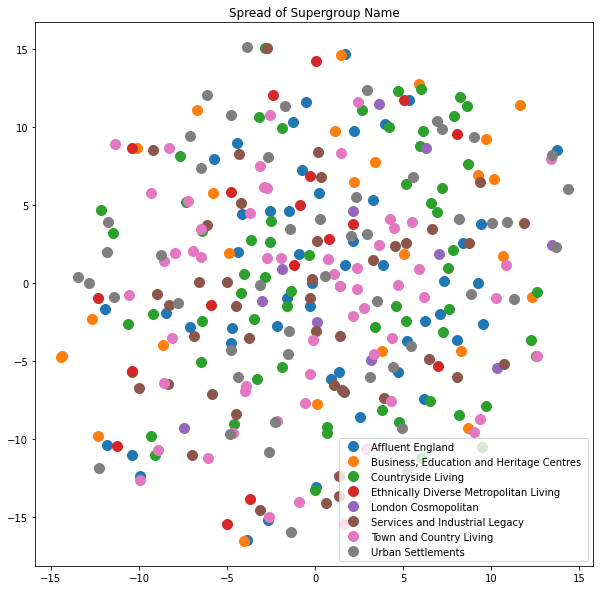

tensor([[ 0.0178, -0.0580,  0.0069,  ..., -0.0231, -0.0755,  0.0661],
        [ 0.0442,  0.0385,  0.0222,  ..., -0.0119, -0.0292, -0.0303],
        [-0.0517, -0.0416,  0.0124,  ..., -0.0051,  0.0206, -0.0736],
        ...,
        [ 0.0009, -0.0275,  0.0323,  ..., -0.0448, -0.0172, -0.0174],
        [ 0.0557, -0.0108,  0.0125,  ...,  0.0180, -0.0092, -0.0053],
        [-0.0568,  0.0460,  0.0377,  ...,  0.0204,  0.0315,  0.0361]])

In [3]:
# Original features
from sklearn.manifold import TSNE

def plot_tsne(tsne, labels, title=''):
    data = pd.DataFrame({'x':tsne[:, 0], 'y':tsne[:, 1], 'label':labels})
    groups = data.groupby('label')
    plt.figure(figsize=(10, 10))
    for name, group in groups:
        plt.plot(group.x, group.y, marker='o', linestyle='', ms=10, label=name)
    plt.legend()
    plt.title(title)
    plt.show()

def tsne(dataset, category_name, feat_idx=None):    
    cluster_df = load_city_cluster_df(numeric=False)
    labels = []
    features = []
    for data in dataset:
        query = cluster_df.query(f'Name == "{data["place"]}"')
        if (query.empty):
            continue
        else:
            labels.append(query[category_name].values[0])
            if feat_idx is not None:
                features.append(torch.index_select(data['x'], 1, feat_idx))
            else:
                features.append(data['x'])
    avg_feats = [torch.mean(feats, dim=0).detach().cpu() for feats in features]
    avg_feats = torch.stack(avg_feats)
    print(avg_feats.shape)
    tsne = TSNE(learning_rate='auto', verbose=1).fit_transform(avg_feats)

    plot_tsne(tsne, labels, title=f'Spread of {category_name}')
    return avg_feats

# Cluster based on original features
include_feats = rank_fields # CHANGE THIS
feat_idx = torch.tensor([feats.index(feat) for feat in include_feats])
dataset = torch.load(f'{dataset_root}/ssx_dataset.pt')
tsne(dataset, 'Supergroup Name')
tsne(dataset, 'Supergroup Name', feat_idx)

# Cluster based on embedded/latent features
single_dataset = torch.load(f'{dataset_root}/link_pred_dataset_transformed.pt')
avg_z_dataset = []
for place in single_dataset:
    zs = single_dataset[place]['transductive']['z'][0]
    avg_z_dataset.append({ 'x': zs, 'place': place })
tsne(avg_z_dataset, 'Supergroup Name')

# Standard MLP For Classification

    geo_labelw         geo_label   geo_code  \
0         None    South Ayrshire  S12000028   
1         None   Huntingdonshire  E07000011   
2         None        Tewkesbury  E07000083   
3         None   West Lancashire  E07000127   
4         None        Darlington  E06000005   
..         ...               ...        ...   
399       None       East Dorset  E07000049   
400       None          Torridge  E07000046   
401       None  Stockton-on-Tees  E06000004   
402       None   Perth & Kinross  S12000024   
403       None             Selby  E07000169   

                                              geometry  train_auc  train_ap  \
0    MULTIPOLYGON (((244282.600 632703.600, 244305....        NaN       NaN   
1    MULTIPOLYGON (((511946.215 290765.599, 511942....   0.838118  0.489380   
2    POLYGON ((378940.315 221169.788, 378941.813 22...   0.849255  0.510672   
3    MULTIPOLYGON (((332523.500 410159.094, 332517....   0.836309  0.474430   
4    POLYGON ((423801.813 514513.500, 42

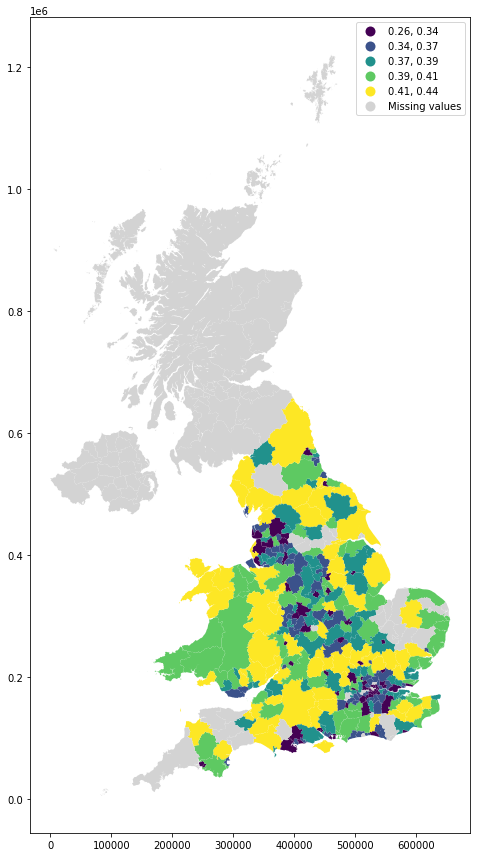

In [4]:
def vizualize_metric(viz_metric):
    link_pred_dataset = torch.load(f'{dataset_root}/link_pred_dataset_transformed.pt')
    zipfile = f'zip://{dataset_root}/infuse_dist_lyr_2011_clipped.zip'
    LA_gdf = gpd.read_file(zipfile)
    
    for place in link_pred_dataset:
        place_metrics = link_pred_dataset[place]
        train_metrics = ['train_auc', 'train_ap', 'test_auc', 'test_ap']
        test_metrics = ['auc', 'ap', 'precision', 'recall', 'f1']
        for metric in train_metrics:
            LA_gdf.loc[(LA_gdf.geo_label == place), metric] = place_metrics[metric]
        for metric in test_metrics:
            LA_gdf.loc[(LA_gdf.geo_label == place), f'{metric}_t'] = place_metrics['transductive'][metric]
            LA_gdf.loc[(LA_gdf.geo_label == place), f'{metric}_i'] = place_metrics['inductive-avg'][metric]
    
    LA_gdf.plot(
        column=viz_metric,
        legend=True,
        scheme='quantiles',
        figsize=(15,15),
        missing_kwds={
            'color': 'lightgrey',
            'label': 'Missing values'
        }
    )
vizualize_metric('test_ap')

In [8]:
link_pred_dataset = torch.load(f'{dataset_root}/link_pred_dataset_transformed.pt')
link_pred_dataset2a = torch.load(f'{dataset_root}/link_pred_metrics_2_iter1.pt')
link_pred_dataset2b = torch.load(f'{dataset_root}/link_pred_metrics_2_iter2.pt')
link_pred_dataset2 = {**link_pred_dataset2a, **link_pred_dataset2b}
zipfile = f'zip://{dataset_root}/infuse_dist_lyr_2011_clipped.zip'
LA_gdf = gpd.read_file(zipfile)

for place in link_pred_dataset:
    if place not in LA_gdf.geo_label.values:
        print(place)
print('NEXT')
        
for place in LA_gdf.geo_label.values:
    if place not in link_pred_dataset:
        print(place)

City of London
Cornwall
Isles of Scilly
Westminster
NEXT
South Ayrshire
Dungannon
Shetland Islands
Eilean Siar
Coleraine
Kirklees
Dumfries & Galloway
Ballymena
Glasgow City
Eden
Norwich
Renfrewshire
Banbridge
Crawley
Carrickfergus
Fenland
Cornwall,Isles of Scilly
North Dorset
East Dunbartonshire
West Lothian
Midlothian
Fife
North Down
Derry
Stirling
Exeter
Larne
Inverclyde
Strabane
Forest Heath
City of London,Westminster
Mid Suffolk
Orkney Islands
Aberdeenshire
East Lothian
Bracknell Forest
Ballymoney
Down
Magherafelt
Limavady
Ards
Cookstown
Armagh
Wealden
West Somerset
Mid Devon
West Dunbartonshire
Worthing
Moyle
Coventry
Scottish Borders
Lisburn
Great Yarmouth
Antrim
Castlereagh
Argyll & Bute
Belfast
Craigavon
Clackmannanshire
Fermanagh
Newtownabbey
North Lanarkshire
East Devon
Broadland
Haringey
Aberdeen City
Dundee City
Kingston upon Hull, City of
Hounslow
Omagh
Moray
St Edmundsbury
Calderdale
King's Lynn and West Norfolk
East Renfrewshire
Wakefield
North Devon
Falkirk
Edinburgh, C

### Models

In [20]:
from torch.nn import Linear, Module, Sequential, ModuleList, Conv1d, MaxPool1d
from torch.nn import Identity, ReLU, Sigmoid, Tanh, LogSoftmax
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, GCN2Conv, GraphConv, DynamicEdgeConv, TopKPooling, MLP
from torch_geometric.nn import global_max_pool as gmp
from torch_geometric.nn import global_mean_pool as gap
from torch_geometric.nn import global_sort_pool as gsp

activations = {
    'none': (lambda x: x),
    'relu': F.relu,
    'sigmoid': F.sigmoid,
    'tanh': F.tanh,
    'logsoft': (lambda x: F.log_softmax(x, dim=-1))
}

gnn_layers = {
    'gcn': GCNConv,
    'gcnii': GCN2Conv,
    'graph': GraphConv
}

# agg_layers = {
#     'max': global_max_pool,
#     'avg': global_mean_pool
# }


class LinearRegression(Module):
    def __init__(self, in_feats, num_classes):
        super(LinearRegression, self).__init__()
        self.layer = Linear(in_feats, num_classes)

    def forward(self, data):
        x, batch = data.x, data.batch
        x = gap(x, batch)
        
        out = self.layer(x)
        return out

class GraphLinear(Linear):
    def forward(self, data, _):
        return super().forward(data)
    
class GraphMLP(Module):
    def __init__(self, in_feats, h_feats, num_layers, num_classes, act=None):
        super(GraphMLP, self).__init__()
        assert num_layers >= 1
        channel_list = [h_feats] * (num_layers - 1)
        channel_list = [in_feats] + channel_list + [num_classes]
        
        layers = []
        for dims in zip(channel_list[:-1], channel_list[1:]):
            layers.append(Linear(*dims))
            layers.append(ReLU())
        self.act = activations[act]
        self.layer = Sequential(*layers)

    def forward(self, data):
        x, batch = data.x, data.batch
        x = gap(x, batch)
        
        out = self.act(self.layer(x))
        return out


class GNN(Module):
    def __init__(self, in_feats, h_feats, num_classes, num_layers, 
                 act='none', dropout=0.5, type='gcn'):
        super(GNN, self).__init__()
        assert num_layers >= 1
        layer = gnn_layers[type]
        
        self.num_layers = num_layers
        self.lin = Linear(h_feats, num_classes)
        self.dropout = dropout
        self.act = activations[act]
        self.layers = ModuleList()
        channel_list = [h_feats] * num_layers
        channel_list = [in_feats] + channel_list
        for dims in zip(channel_list[:-1], channel_list[1:]):
            self.layers.append(layer(*dims))

    def forward(self, data):
        # data should have the following 3 attributes
        x, edge_index, batch = data.x, data.edge_index, data.batch

        for layer in self.layers:
            x = layer(x, edge_index)
            x = F.relu(x)
            x = F.dropout(x, p=self.dropout, training=self.training)            
            
        x = gap(x, batch)
        x = F.dropout(x, p=self.dropout, training=self.training)
        x = self.act(self.lin(x))
        
        return x
    

class TopKGNN(Module):
    def __init__(self, in_feats, h_feats, num_classes, type='graph', act='none'):
        super().__init__()
        gnn_layer = gnn_layers[type]
        
        self.conv1 = gnn_layer(in_feats, h_feats)
        self.pool1 = TopKPooling(h_feats, ratio=0.8)
        self.conv2 = gnn_layer(h_feats, h_feats)
        self.pool2 = TopKPooling(h_feats, ratio=0.8)
        self.conv3 = gnn_layer(h_feats, h_feats)
        self.pool3 = TopKPooling(h_feats, ratio=0.8)

        self.lin1 = torch.nn.Linear(h_feats * 2, h_feats)
        self.lin2 = torch.nn.Linear(h_feats, h_feats // 2)
        self.lin3 = torch.nn.Linear(h_feats // 2, num_classes)
        
        self.act = activations[act]

    def forward(self, data):
        x, edge_index, batch = data.x, data.edge_index, data.batch

        x = F.relu(self.conv1(x, edge_index))
        x, edge_index, _, batch, _, _ = self.pool1(x, edge_index, None, batch)
        x1 = torch.cat([gmp(x, batch), gap(x, batch)], dim=1)

        x = F.relu(self.conv2(x, edge_index))
        x, edge_index, _, batch, _, _ = self.pool2(x, edge_index, None, batch)
        x2 = torch.cat([gmp(x, batch), gap(x, batch)], dim=1)

        x = F.relu(self.conv3(x, edge_index))
        x, edge_index, _, batch, _, _ = self.pool3(x, edge_index, None, batch)
        x3 = torch.cat([gmp(x, batch), gap(x, batch)], dim=1)

        x = x1 + x2 + x3

        x = F.relu(self.lin1(x))
        x = F.dropout(x, p=0.5, training=self.training)
        x = F.relu(self.lin2(x))
        # x = self.lin3(x)
        x = self.act(self.lin3(x))
        return x

class DGCNN(torch.nn.Module):
    def __init__(self, in_feats, hidden_channels, num_classes, num_layers,
                 train_dataset, GNN=GCNConv, k=0.6, act='none'):
        super().__init__()

        if k < 1:  # Transform percentile to number.
            num_nodes = sorted([data.num_nodes for data in train_dataset])
            k = num_nodes[int(math.ceil(k * len(num_nodes))) - 1]
            k = max(10, k)
        self.k = int(k)

        self.convs = ModuleList()
        self.convs.append(GNN(in_feats, hidden_channels))
        for i in range(0, num_layers - 1):
            self.convs.append(GNN(hidden_channels, hidden_channels))
        self.convs.append(GNN(hidden_channels, 1))

        conv1d_channels = [16, 32]
        total_latent_dim = hidden_channels * num_layers + 1
        conv1d_kws = [total_latent_dim, 5]
        self.conv1 = Conv1d(1, conv1d_channels[0], conv1d_kws[0],
                            conv1d_kws[0])
        self.maxpool1d = MaxPool1d(2, 2)
        self.conv2 = Conv1d(conv1d_channels[0], conv1d_channels[1],
                            conv1d_kws[1], 1)
        dense_dim = int((self.k - 2) / 2 + 1)
        dense_dim = (dense_dim - conv1d_kws[1] + 1) * conv1d_channels[1]
        self.mlp = MLP([dense_dim, 128, num_classes], dropout=0.5, batch_norm=False)
        self.act = activations[act]

    def forward(self, data):
        x, edge_index, batch = data.x, data.edge_index, data.batch
        xs = [x]
        for conv in self.convs:
            xs += [conv(xs[-1], edge_index).tanh()]
        x = torch.cat(xs[1:], dim=-1)

        # Global pooling.
        x = gsp(x, batch, self.k)
        x = x.unsqueeze(1)  # [num_graphs, 1, k * hidden]
        x = self.conv1(x).relu()
        x = self.maxpool1d(x)
        x = self.conv2(x).relu()
        x = x.view(x.size(0), -1)  # [num_graphs, dense_dim]

        return self.act(self.mlp(x))


class GNNBetMLP(Module):
    def __init__(self, nhid,dropout):
        super(GNNBetMLP, self).__init__()
        self.dropout = dropout
        self.linear1 = torch.nn.Linear(nhid,2*nhid)
        self.linear2 = torch.nn.Linear(2*nhid,2*nhid)
        self.linear3 = torch.nn.Linear(2*nhid,1)


    def forward(self,input_vec,dropout):

        score_temp = F.relu(self.linear1(input_vec))
        score_temp = F.dropout(score_temp,self.dropout)
        score_temp = F.relu(self.linear2(score_temp))
        score_temp = F.dropout(score_temp,self.dropout)
        score_temp = self.linear3(score_temp)

        return score_temp
    

# Only for single output
class GNNBetFullMLP(GNN):
    def __init__(self, in_feats, h_feats, num_layers, dropout, agg='gcn'):
        super(GNNBetFullMLP, self).__init__(in_feats, h_feats, h_feats, 
                                            num_layers, dropout=dropout, type=agg)
        self.score_layer = GNNBetMLP(h_feats * num_layers, self.dropout)

    def forward(self, data):
        # data should have the following 3 attributes
        x, edge_index, batch = data.x, data.edge_index, data.batch
        embeddings = []
        
        #Layers for aggregation operation
        for layer in self.layers:
            x = layer(x, edge_index)
            x = F.relu(x)
            x = F.dropout(x, p=self.dropout, training=self.training)
            x = F.normalize(x, p=2, dim=1)
            x_agg = gap(x, batch)
            embeddings.append(x_agg)
            
        
        full_embedding = torch.cat(embeddings, dim=1)
        score = self.score_layer(full_embedding, self.dropout)
        
        return score

## Graph Regression/Classification

In [21]:
from sklearn.metrics import r2_score

learning_rate = 0.0002
h_feats = 32
target_index = 0
dropout = 0.6
num_node_features, num_classes = get_data_stats(train_loader.dataset, target_index)
num_layers = 3

model = DGCNN(num_node_features, h_feats, num_classes, num_layers, train_loader.dataset)
# model = GNNBetFullMLP(num_node_features, h_feats, num_layers, dropout)
# model = GNN(num_node_features, h_feats, num_classes, num_layers, act='logsoft')
# model = TopKGNN(num_node_features, h_feats, num_classes)
# model = GraphMLP(num_node_features, h_feats, num_layers, num_classes)
# model = LinearRegression(num_node_features, num_classes)
print(model)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
criterion = torch.nn.MSELoss() if num_classes == 1 else torch.nn.NLLLoss()

def train():
    model.train()

    for data in train_loader:  # Iterate in batches over the training dataset.
        optimizer.zero_grad()  # Clear gradients.
        out = model(data)  # Perform a single forward pass.
        target = data.y.unsqueeze(1).float() if num_classes == 1 else data.y[:,target_index].long()
        loss = criterion(out, target)  # Compute the loss.
        loss.backward()  # Derive gradients.
        optimizer.step()  # Update parameters based on gradients.

def test(loader):
    model.eval()

    correct = 0
    for data in loader:  # Iterate in batches over the training/test dataset.
        out = model(data)
        if num_classes == 1:
            out = out.squeeze(1).cpu().detach()
            correct += r2_score(data.y.cpu().detach(), out)  # Check correlation against ground-truth.
        else:
            pred = out.argmax(dim=1)  # Use the class with highest probability.
            correct += int((pred == data.y[:,target_index]).sum())  # Check against ground-truth labels.
    return correct / len(loader.dataset)  # Derive average correlation.

num_epochs = 100
print_every = 1
train_losses = []
test_losses = []
for epoch in range(num_epochs):
    train()
    train_acc = test(train_loader)
    test_acc = test(test_loader)
    if (epoch + 1) % print_every == 0:
            start = len(train_losses) - print_every
            mean_train = np.mean(train_losses[start:])
            mean_test = np.mean(test_losses[start:])
            print(f'Epoch: {epoch + 1:03d}, Train: {mean_train:.4f}, Val: {mean_test:.4f}')
    train_losses.append(train_acc)
    test_losses.append(test_acc)

DGCNN(
  (convs): ModuleList(
    (0): GCNConv(17, 32)
    (1): GCNConv(32, 32)
    (2): GCNConv(32, 32)
    (3): GCNConv(32, 1)
  )
  (conv1): Conv1d(1, 16, kernel_size=(97,), stride=(97,))
  (maxpool1d): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv1d(16, 32, kernel_size=(5,), stride=(1,))
  (mlp): MLP(77760, 128, 8)
)


/vol/bitbucket/wwc4618/venv/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/vol/bitbucket/wwc4618/venv/lib/python3.8/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Epoch: 001, Train: nan, Val: nan
Epoch: 002, Train: 0.2094, Val: 0.2000
Epoch: 003, Train: 0.2094, Val: 0.2000
Epoch: 004, Train: 0.2094, Val: 0.2000
Epoch: 005, Train: 0.2094, Val: 0.2000
Epoch: 006, Train: 0.2094, Val: 0.2000
Epoch: 007, Train: 0.2094, Val: 0.2000
Epoch: 008, Train: 0.2094, Val: 0.2000
Epoch: 009, Train: 0.2094, Val: 0.2000
Epoch: 010, Train: 0.2094, Val: 0.2000
Epoch: 011, Train: 0.2094, Val: 0.2000
Epoch: 012, Train: 0.2094, Val: 0.2000
Epoch: 013, Train: 0.2094, Val: 0.2000


KeyboardInterrupt: 

In [ ]:
# Load data
g, loader = load_data(training_places, num_val=0.2, num_parts=1024,
                      num_classes=0, batch_size=128,
                      reload=True, verbose=True)
